<a href="https://colab.research.google.com/github/jinu9688/VI_lecture_homework-1/blob/main/vehicle_detection_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##20163331 전진우 차량지능기초 과제1
##2) (1) vehicle_detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import matplotlib.image as mpimg
import time

start=time.time()

images = glob.glob('/content/drive/MyDrive/Colab_Notebooks/colab_git/VehicleDetection/vehicles/KITTI_extracted/*.png')
images += glob.glob('/content/drive/MyDrive/Colab_Notebooks/colab_git/VehicleDetection/non-vehicles/**/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(mpimg.imread(image))
    else:
        cars.append(mpimg.imread(image))

print("time :",time.time() - start)
print('Images loaded.')

#glob를 사용하여 image를 불러온다.
#각 이미지는 google-drive와 연동하여 불러오고 car image와 car가 아닌 notcar image로 분류한다.

In [ ]:
import cv2
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
#함수 설정에 필요한 모듈들을 불러온다.
#cv2는 openCV를 통해 이미지 파일을 읽고 보고 저장할 수 있는 모듈이다
#matplotlib는 그래프를 그릴 수 있게 도와주는 모듈이다
#아래에서 hog를 사용하기 위해서 skimage.feature모듈에서 가져온다.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):  
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features
#get_hog_features함수는 HOG기능 및 시각화를 반환하는 함수이다. 
#HOG는 대상 영역을 일정 크기의 셀로 분할하고, 각 셀마다 edge 픽셀(gradient magnitude가 
#일정 값 이상인 픽셀)들의 방향에 대한 히스토그램을 구한 후 이들 히스토그램 bin 값들을 일렬로 
#연결한 벡터이다. 즉, HOG는 edge의 방향 히스토그램 템플릿으로 볼 수 있다.
#feature와 hog_image가 같으면 두 출력으로, 그렇지 않으면 한 출력으로 호출한다.


def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features
#bin_spatial함수는 빈 색상의 특징을 계산하는 함수이다.
#cv2.resize().ravel()을 사용하여 형상 벡터를 생성한다.
#그 후 feature를 반환한다.


def color_hist(img, nbins=32, bins_range=(0., 1.)):

    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features
#color_hist함수는 색상 히스토그램 기능을 계산하는 함수이다.
#mpimg로 .png파일을 읽는 경우 bins_range을 변경해야하기 때문에 사용한다.
#커널 채널의 히스토그램을 별도로 계산하여 단일 형상 벡터에 연결하고 이들을 반환한다.


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
 #extract_features함수는 영상 목록에서 형상을 추출하는 기능을 한다.
 #이 기능들을 bin_spatial(), color_hist()라고 정의한다.

    features = []    #형상 벡터를 추가할 목록을 작성할 빈 리스트를 작성한다.
    for image in imgs:
        file_features = []
        if color_space != 'RGB': #RGB 이외의 경우에 색상 변환을 적용한다.
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat: #새로운 feature들을 기존 feature목록에 추가한다.
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features #최종적으로 형상 벡터의 feature를 반환한다.


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#slide_window함수는 이미지를 촬영하는 기능을 정의한다.
#x와 y의 시작과 정지 위치, 창 크기(x,y 크기), 겹치는 부분에 대해 정의한다

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    else:
        y_start_stop[0] = int(img.shape[0] * y_start_stop[0] / 100.)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    else:
        y_start_stop[1] = int(img.shape[0] * y_start_stop[1] / 100.)
#x또는 y, 시작과 정지 위치가 정의되지 않은 경우에 영상 크기로 설정한다.
    print("Y start and stop: {}".format(y_start_stop))

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
#위는 검색할 영역의 범위를 계산한다.
#step당 pixel수를 x/y단위로 계산하고 창 수도 계산한다.
#목록을 초기화한다. 
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list
#x와 y윈도우 위치를 찾는 for 반복문이다. 
#창을 위치를 계산하고 목록에 창 위치를 추가해 창 목록을 반환한다.

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
#draw_boxex는 경계 상자를 그리는 기능을 정의한다.
#이미지를 복사하고 경계 상자 사이를 반복한다. 
#주어진 bbox 좌표를 그리고 최종적으로 box가 그려진 이미지 복사본을 반환한다.


In [ ]:
import cv2
import numpy as np
from lesson_functions import bin_spatial, color_hist, get_hog_features
#위와 마찬가지로 필요한 모듈들을 가져온다.

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
#single_img_features함수는 단일 이미지 창에서 형상을 추출하는 기능을 정의한다.
#extract_feature과 유사하며 이미지 리스트가 아닌 단일 이미지용이다.
    img_features = [] #기능을 수신할 빈 목록을 정의한다.
    if color_space != 'RGB': #RGB이외의 경우 색상 변환을 적용한다.
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    if spatial_feat:  #flag가 설정된 경우 공간 특성을 계산한다.
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features) #img_feature목록에 특정 feature를 추가한다.
    if hist_feat:  #flag가 설정된 경우 히스토그램 feature를 계산한다.
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features) #img_feature목록에 특정 feature를 추가한다.
    if hog_feat: #flag가 설정된 경우 HOG feature를 계산한다.
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features) #img_feature목록에 특정 feature를 추가한다.
    return np.concatenate(img_features)
#최종적으로 img_feature를 반환한다.

def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
#search_windows함수는 이미지를 전달하는 기능을 정의한다.

    on_windows = [] #빈 목록을 생성한다.
    for window in windows: #목록의 모든 window창에 반복한다.
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #원본 영상에서 test_window를 추출한다.
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        #single_img_feature를 사용하여 해당 window창의 feature를 추출한다.
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #추출된 feature를 분류기로 전달한다.
        prediction = clf.predict(test_features)
        #분류기를 사용하여 예측한다
        if prediction == 1:
            on_windows.append(window)
    return on_windows
        #최종적으로on_windows를 반환한다.

In [ ]:
color_space = 'HSV'  #color_space를 HSY로 지정한다.
orient = 8           #HOG orient=8로 지정한다.
pix_per_cell = 8     #HOG의 셀 당 pixel수=8로 지정한다.
cell_per_block = 2   #HOG의 block 당 셀 수=2로 지정한다.
hog_channel = 'ALL'  #HOG 채널은 ALL로 지정한다.
spatial_size = (32, 32)  #차원 공간 치수를 지정한다.
hist_bins = 16           #히스토그램의 bin을 지정한다.
spatial_feat = False     #공간적 특징은 끈다.
hist_feat = True         #히스토그램 feature기능을 켠다.
hog_feat = True          #HOG feature기능을 켠다.
y_start_stop = [50, 100] #slide_window에서 검색할 최소값과 최대값을 정의한다.

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
#각 열당 scaler를 정의한다.
scaled_X = X_scaler.transform(X)
#scaler를 x에 저장한다.
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
#라벨 벡터를 정의하고, 데이터를 랜덤화된 훈련 및 시험 세트로 분할한다.
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
#선형 SVC를 사용한다.
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t = time.time()
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
#SVC의 time.time 훈련 시간을 확인하고 SVC score를 확인한다.

image = image.astype(np.float32)/255
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                       xy_window=(96, 96), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
#훈련을 진행한 후 다음 열의 주석을 제거한다.

plt.imshow(window_img)
plt.show()
#최종적으로 차량에 대한 경계box가 생성된 모습을 볼 수 있다.


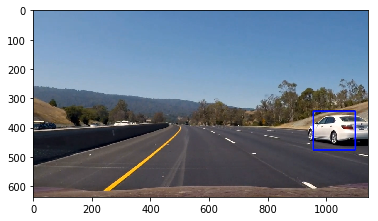

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('/content/drive/MyDrive/Colab_Notebooks/colab_git/VehicleDetection/1.png')
plt.imshow(image)